# Flow based models

So far, we have covered a class of generative models that estimate the probability distribution $p(\mathbf{x})$ in an autoregressive manner. However, these models suffer from a few drawbacks, including:

1. Slow sampling speed
2. Lack a latent representation

In this chapter, we discuss flow based models, which are constructed by finding a mapping $f$ that transforms the original distribution $p_\mathbf{x}(x)$ to a simpler distribution $p_\mathbf{z}(z)$ (for example, a Gaussian distribution). We can then generate new samples by sampling from the distribution $p_Z(z)$ and then applying the inverse transformation $f^{-1}$. 

<head>
  <meta charset="UTF-8">
  <title>Katex</title>
  <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.min.css" integrity="sha384-zB1R0rpPzHqg7Kpt0Aljp8JPLqbXI3bhnPWROx27a9N0Ll6ZP/+DiW/UqRcLbRjq" crossorigin="anonymous">
  <script defer src="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.min.js" integrity="sha384-y23I5Q6l+B6vatafAwxRu/0oK/79VlbSz7Q9aiSZUvyWYIYsd+qj+o24G5ZU2zJz" crossorigin="anonymous"></script>
  <script defer src="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/contrib/auto-render.min.js" integrity="sha384-kWPLUVMOks5AQFrykwIup5lo0m3iMkkHrD0uJ4H5cjeGihAutqP0yW0J6dpFiVkI" crossorigin="anonymous" onload="renderMathInElement(document.body);"></script>
</head>

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Flow/figures/FLOW.png" style="max-width: 55%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px;"> 
    <strong> Figure 1 </strong>: Flow-based model.
</p>

To train the model, we maximize the log-likelihood, which, by applying the change of variables formula, can be expressed as

$$p_\mathbf{x}(x) = p_{\mathbf{z}}(z) \bigg|\frac{df}{d\mathbf{x}}\bigg| \implies \log p_\mathbf{x}(x) = \log p_{\mathbf{z}}(z) + \log \bigg|\frac{df}{d\mathbf{x}}\bigg|$$

Where $|\frac{df}{d\mathbf{x}}|$ denotes the Jacobian of $f$ with respect to $\mathbf{x}$. We can choose the latent variable $\mathbf{z}$ so that $p_{\mathbf{z}}(z)$ takes a simple form. It remains choosing a suitable mapping $f$. We want to choose $f$ so that the following requirement are met

1. Invertible: need to be able to sample
2. Differentiable: for optimization
3. The Jacobian takes in simple form: so that the log-likelihood is easy to evaluate

In this section, we discuss different design choices of the invertible mapping $f$. We start with a toy example.

## Toy example: Mixture of Gaussians

Suppose we have 3000 samples from a mixture of three Gaussians, with unknown weights, mean, and variance. 

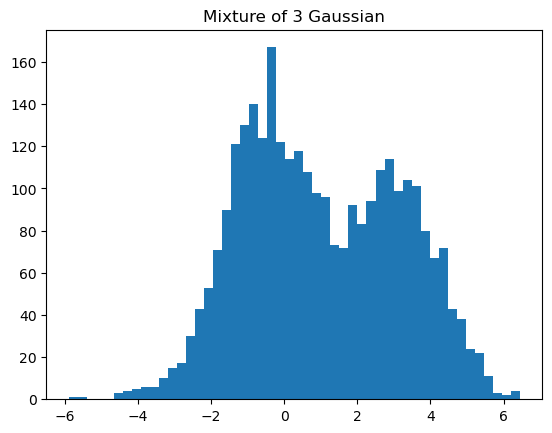

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.distributions.uniform import Uniform
import torch.optim as optim
from scipy.interpolate import interp1d
from glow import *

train_dataloader = generate_data(3000)

We want to find a transformation $f$ that maps $p_{\mathbf{x}}(x)$ to the uniform distribution $p_{\mathbf{z}}(z)$. Recall that for any random variable $\mathbf{x}$, the distribution of $\mathbf{z}=F_\mathbf{x}(\mathbf{x})$ follows a uniform distribution since

$$F_\mathbf{z}(z)=\mathbb{P}\{\mathbf{z}\leq z\} = \mathbb{P}\{F_\mathbf{x}(\mathbf{x})\leq z\} = \mathbb{P}\{\mathbf{x}\leq F_\mathbf{x}^{-1}(z)\} = F_\mathbf{x}(F_\mathbf{x}^{-1}(z))=z$$

Since we know $p_\mathbf{x}(x)$ is a mixture of three Gaussians. We have 

$$p_\mathbf{x}(x) = w_1\mathcal{N}(x; \mu_1, \sigma_1) + w_2\mathcal{N}(x; \mu_2, \sigma_2) + w_3\mathcal{N}(x; \mu_3, \sigma_3)$$

Therefore, if we choose $f$ to be the c.d.f of $p_\mathbf{x}(x)$, then the output is guaranteed to be a uniform distribution. This suggests that we can parameterize $f$ as 

$$z=f(x)=w_1\Phi(x;\mu_1, \sigma_1) + w_2\Phi(x;\mu_2, \sigma_2) + w_3\Phi(x;\mu_3, \sigma_3)$$

Using the change of variables formula gives us

$$\log p_\mathbf{x}(x) = \log p_{\mathbf{z}}(z) + \log \bigg|\frac{df}{d\mathbf{x}}\bigg|$$

The log-likelihood of the data $\{x_i\}_{\in [n]}$ is then given by 

$$
\begin{align*}
     \sum_{i=1}^n \log p_\mathbf{x}(x_i) &= \sum_{i=1}^n \log p_\mathbf{z}(f(x_i)) + \sum_{i=1}^n \log \bigg|\frac{df}{d\mathbf{x}}(x_i)\bigg|\\
     &= \sum_{i=1}^n \log f(x_i) + \sum_i \log \bigg|w_1\Phi_1'(x_i) + w_2\Phi_2'(x_i)+ w_3\Phi_3'(x_i)\bigg|\\
\end{align*}
$$

In [6]:
class MixtureFlow(nn.Module):
    """
    Implementation of the toy example flow problem:
    The model stores the parameters w, mu, and sigma
    In the forward method, the model return f(x) and f'(x)
    """
    def __init__(self):
        super(MixtureFlow, self).__init__()
        self.w_logits = nn.Parameter(torch.randn(3, ))
        self.mu = nn.Parameter(torch.randn(3, ))
        self.log_sigma = nn.Parameter(torch.randn(3, ))
        
    def forward(self, X):
        weights = self.w_logits.softmax(dim=0)
        distribution = Normal(self.mu, self.log_sigma.exp())
        z = (distribution.cdf(X) * weights).sum(dim=1)
        dz = (distribution.log_prob(X).exp() * weights).sum(dim=1)
        return z, dz

We train the model with $200$ epochs using Adam optimizer with learning rate $0.3$. 

In [ ]:
mixture = MixtureFlow()
loss = train(mixture, train_dataloader, Uniform(0.0, 1.0), epochs=200)

We see that the transformation indeed transforms our data into a uniform distribution. 

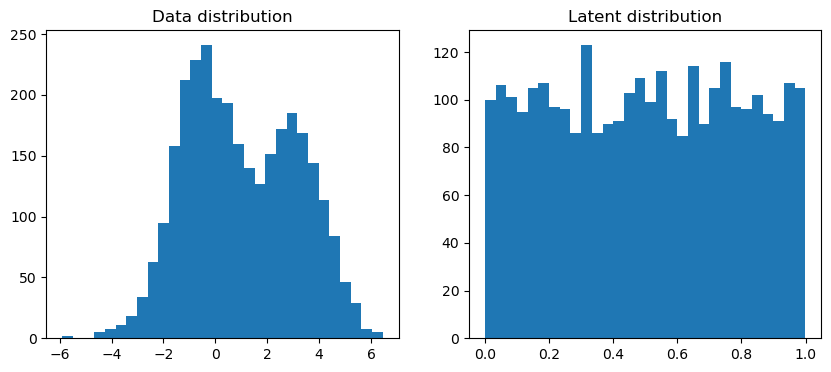

In [10]:
z, _ = mixture(train_data.unsqueeze(-1))
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data, bins=30)
ax[0].set_title("Data distribution")
ax[1].hist(z.detach().numpy(), bins=30)
ax[1].set_title("Latent distribution")
plt.show()

We can also plot the final flow function. Note that the function is clearly invertible.

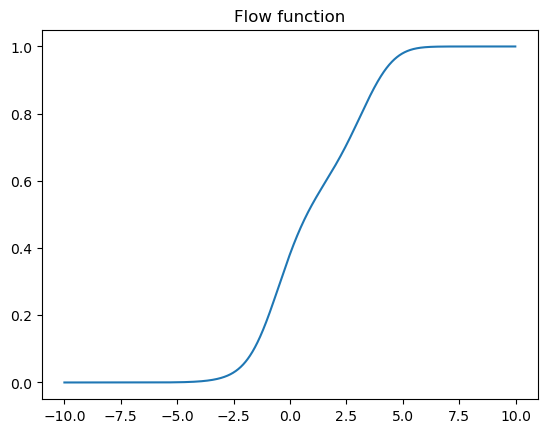

In [11]:
x = torch.arange(-10, 10, 0.01)
z, _ = mixture(x.unsqueeze(-1))
z = z.detach().numpy()
plt.plot(x, z)
plt.title("Flow function")
plt.show()

We now generate samples by first sampling from the uniform distribution and then apply the inverse transformation $f^{-1}$. Note that the generated sample is closely related to the generated samples. 

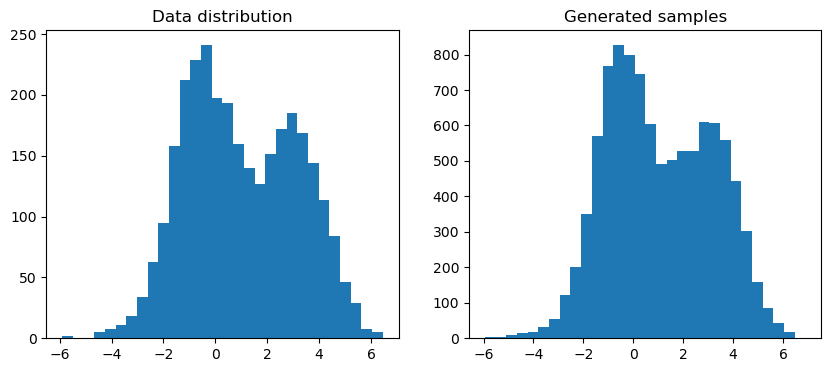

In [13]:
interp_func = interp1d(z, x, kind='linear', bounds_error=False, fill_value='extrapolate')

samples = []
for q in np.random.rand(10000):
    samples.append(interp_func(q))
    
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data, bins=30)
ax[0].set_title("Data distribution")
ax[1].hist(samples, bins=30)
ax[1].set_title("Generated samples")
plt.show()